In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [103]:
# Loading the data from package
#DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/datasets/"
#counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_counts_cnv_v2.csv"), index_col=0)
#counts_df = counts_df.T
#metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_v2.csv"), index_col=0)

In [381]:
# Test real data
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/simulations/data/replicates/"
counts_df = pd.read_csv(os.path.join(DATA_PATH, "10_rna_join_40_5000.csv"), index_col=0)
counts_df = counts_df.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "10_metadata_40_5000.csv"), index_col=0)

In [7]:
#Data filtering
#genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
#counts_df = counts_df[genes_to_keep]
counts_df.shape

(20, 1000)

In [383]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()

dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

# Statistical analysis
stat_res = DeseqStats(dds, 
                      alpha=0.05, 
                      cooks_filter=True, 
                      independent_filter=True)

stat_res.run_wald_test()

if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

# p-value adjustment

if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

stat_res.summary()

stat_res.lfc_shrink(coeff="condition_B_vs_A")

#Save results
OUTPUT_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/simulations/results/replicates_pydeseq/cn_naive"
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "10_res_CNnaive_40_5000.csv"))

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.55 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.83 seconds.

Fitting LFCs...
... done in 0.30 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 12 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.27 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition B vs A
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
g1        966.909898        0.925919  0.179713   5.152215  2.574282e-07   
g2     950123.636005        1.333213  0.184089   7.242201  4.414594e-13   
g3       2095.307833        1.845823  0.175774  10.501095  8.538411e-26   
g4       7310.527914        1.071273  0.456102   2.348758  1.883614e-02   
g5        302.566482        1.677963  0.283584   5.916982  3.279033e-09   
...              ...             ...       ...        ...           ...   
g4996     332.793980       -0.204762  0.140373  -1.458694  1.446492e-01   
g4997    3769.803549       -0.336310  0.124365  -2.704214  6.846625e-03   
g4998   11738.867821        0.011890  0.166826   0.071274  9.431796e-01   
g4999    1711.546521       -0.151351  0.157248  -0.962494  3.358014e-01   
g5000    1136.424067       -0.415842  0.287139  -1.448224  1.475545e-01   

               padj  
g1     1.321500e-06  


... done in 0.82 seconds.



In [57]:
#dds.obsm["size_factors"]
#dds.varm["genewise_dispersions"]
#dds.varm["fitted_dispersions"]
#print(
    #f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
#)
#dds.varm["MAP_dispersions"]
#dds.varm["dispersions"]
#dds.varm["LFC"]

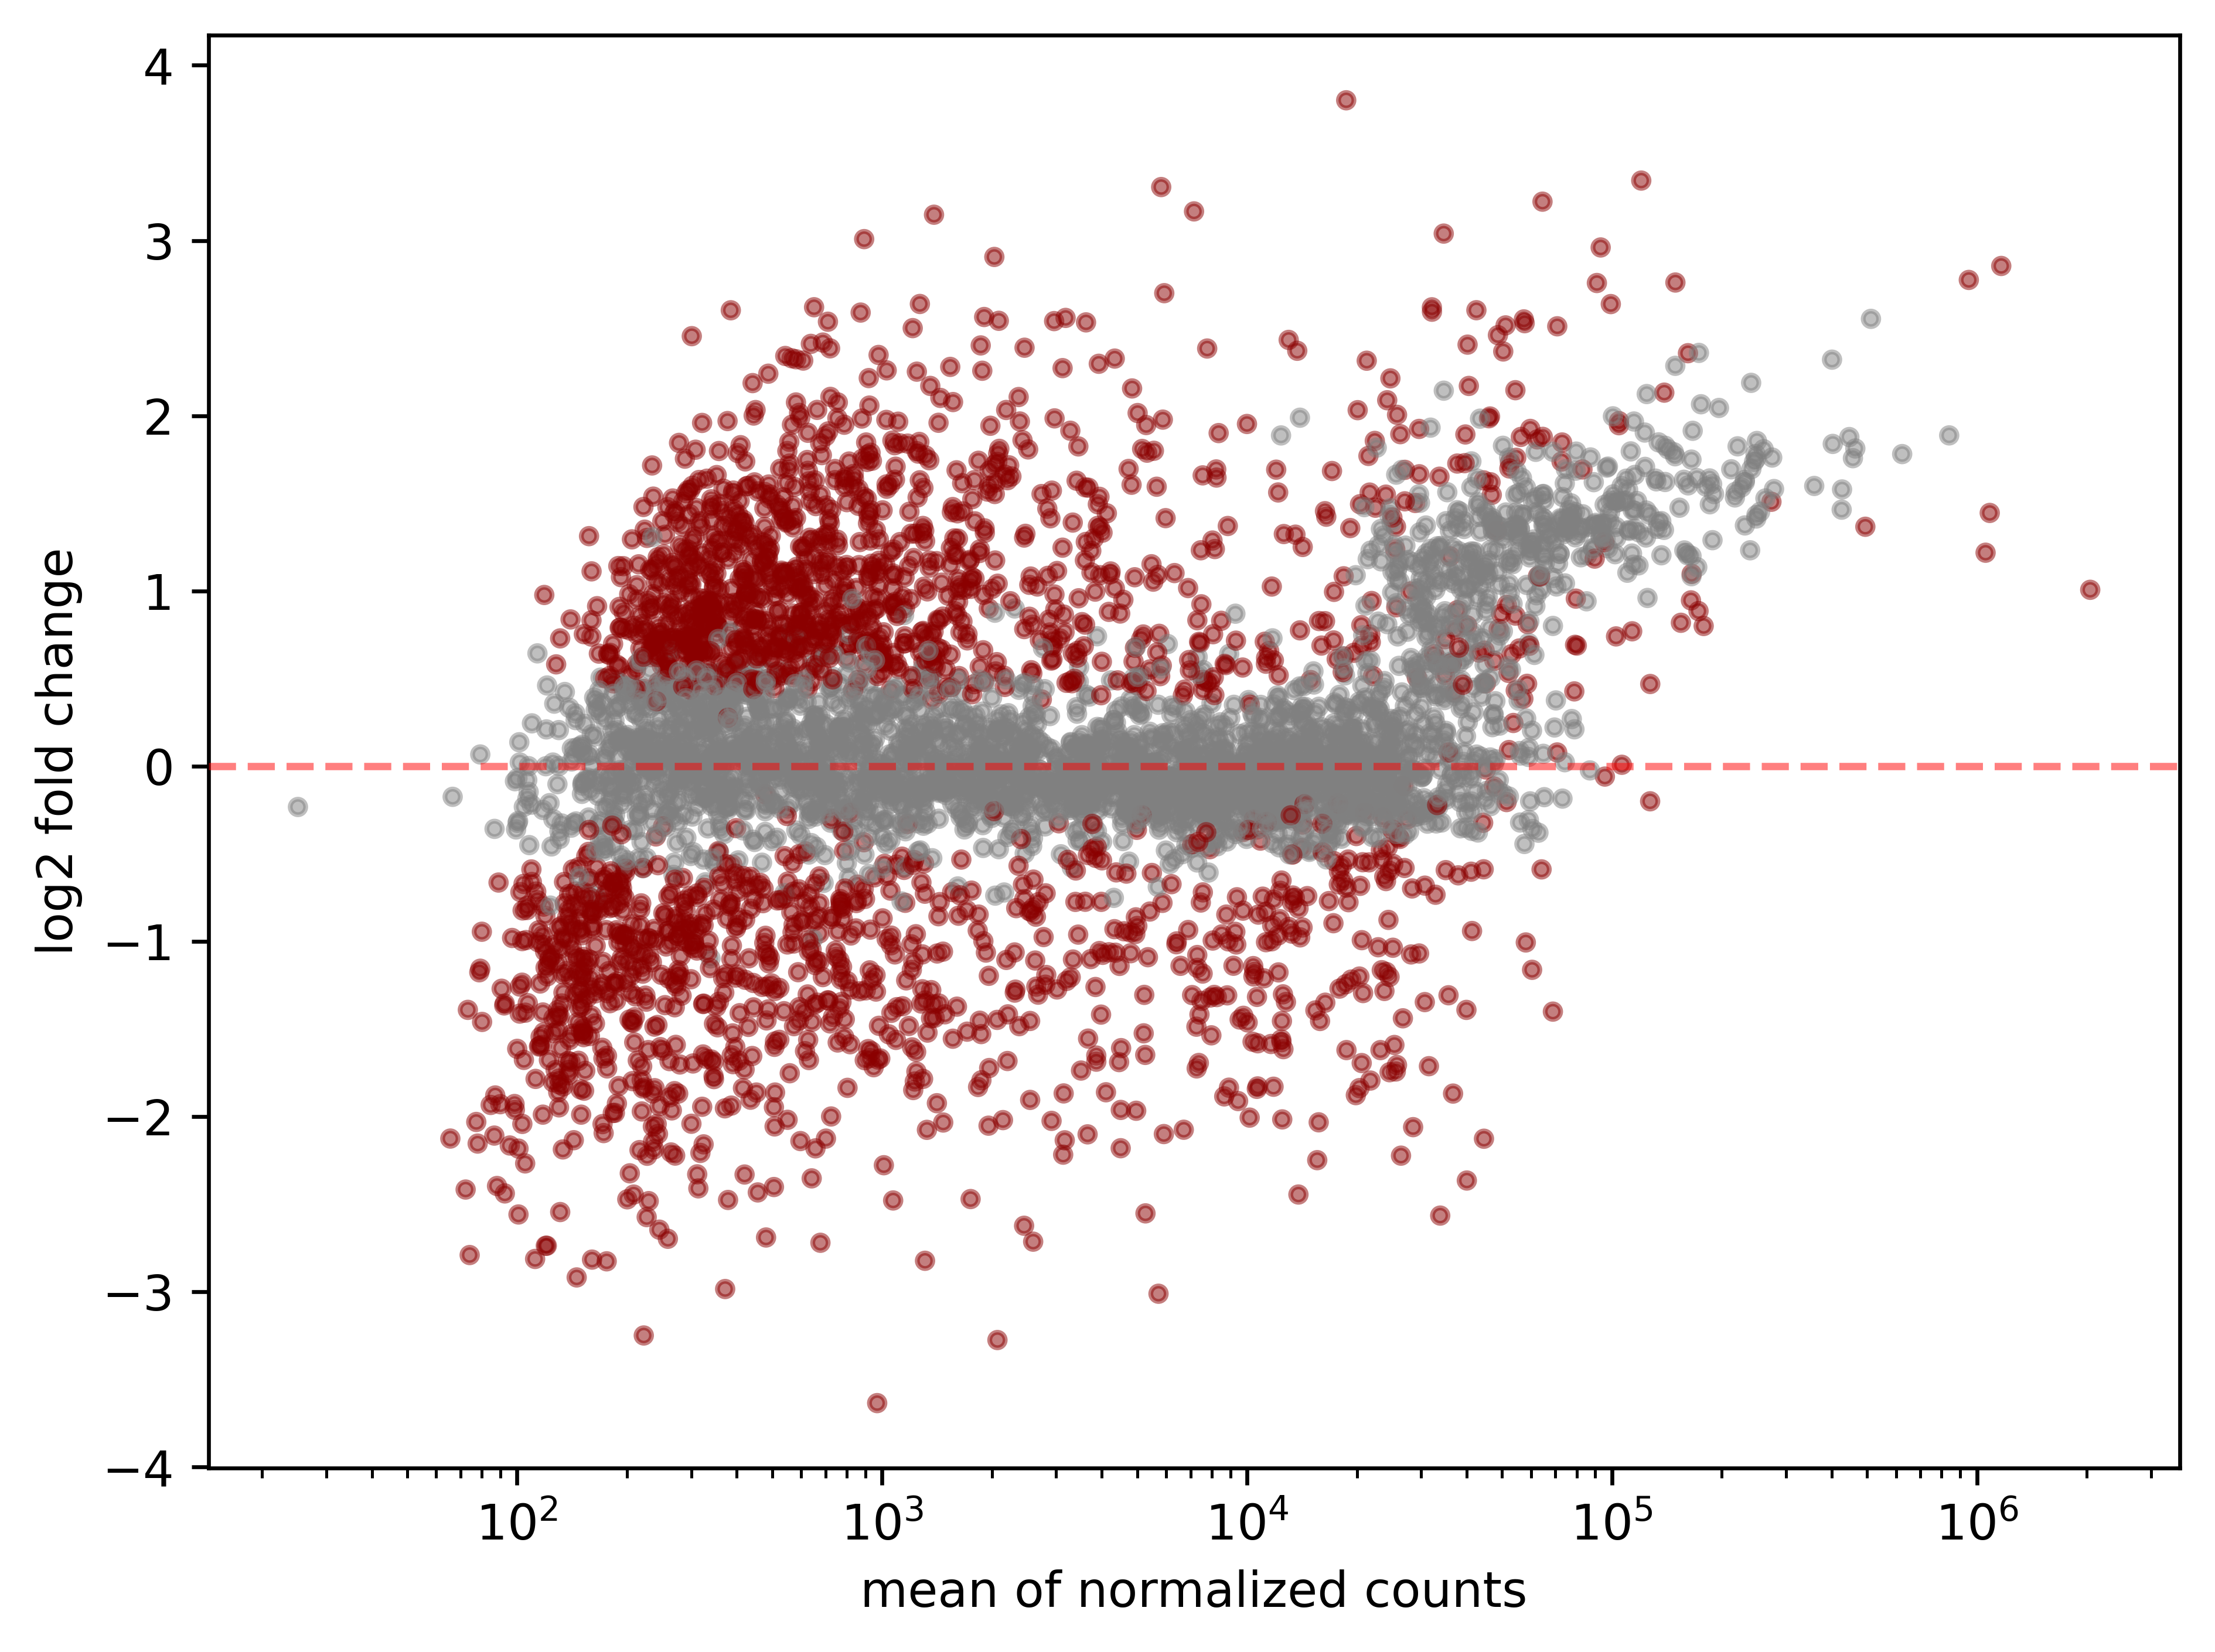

In [385]:
stat_res.plot_MA(s=10)